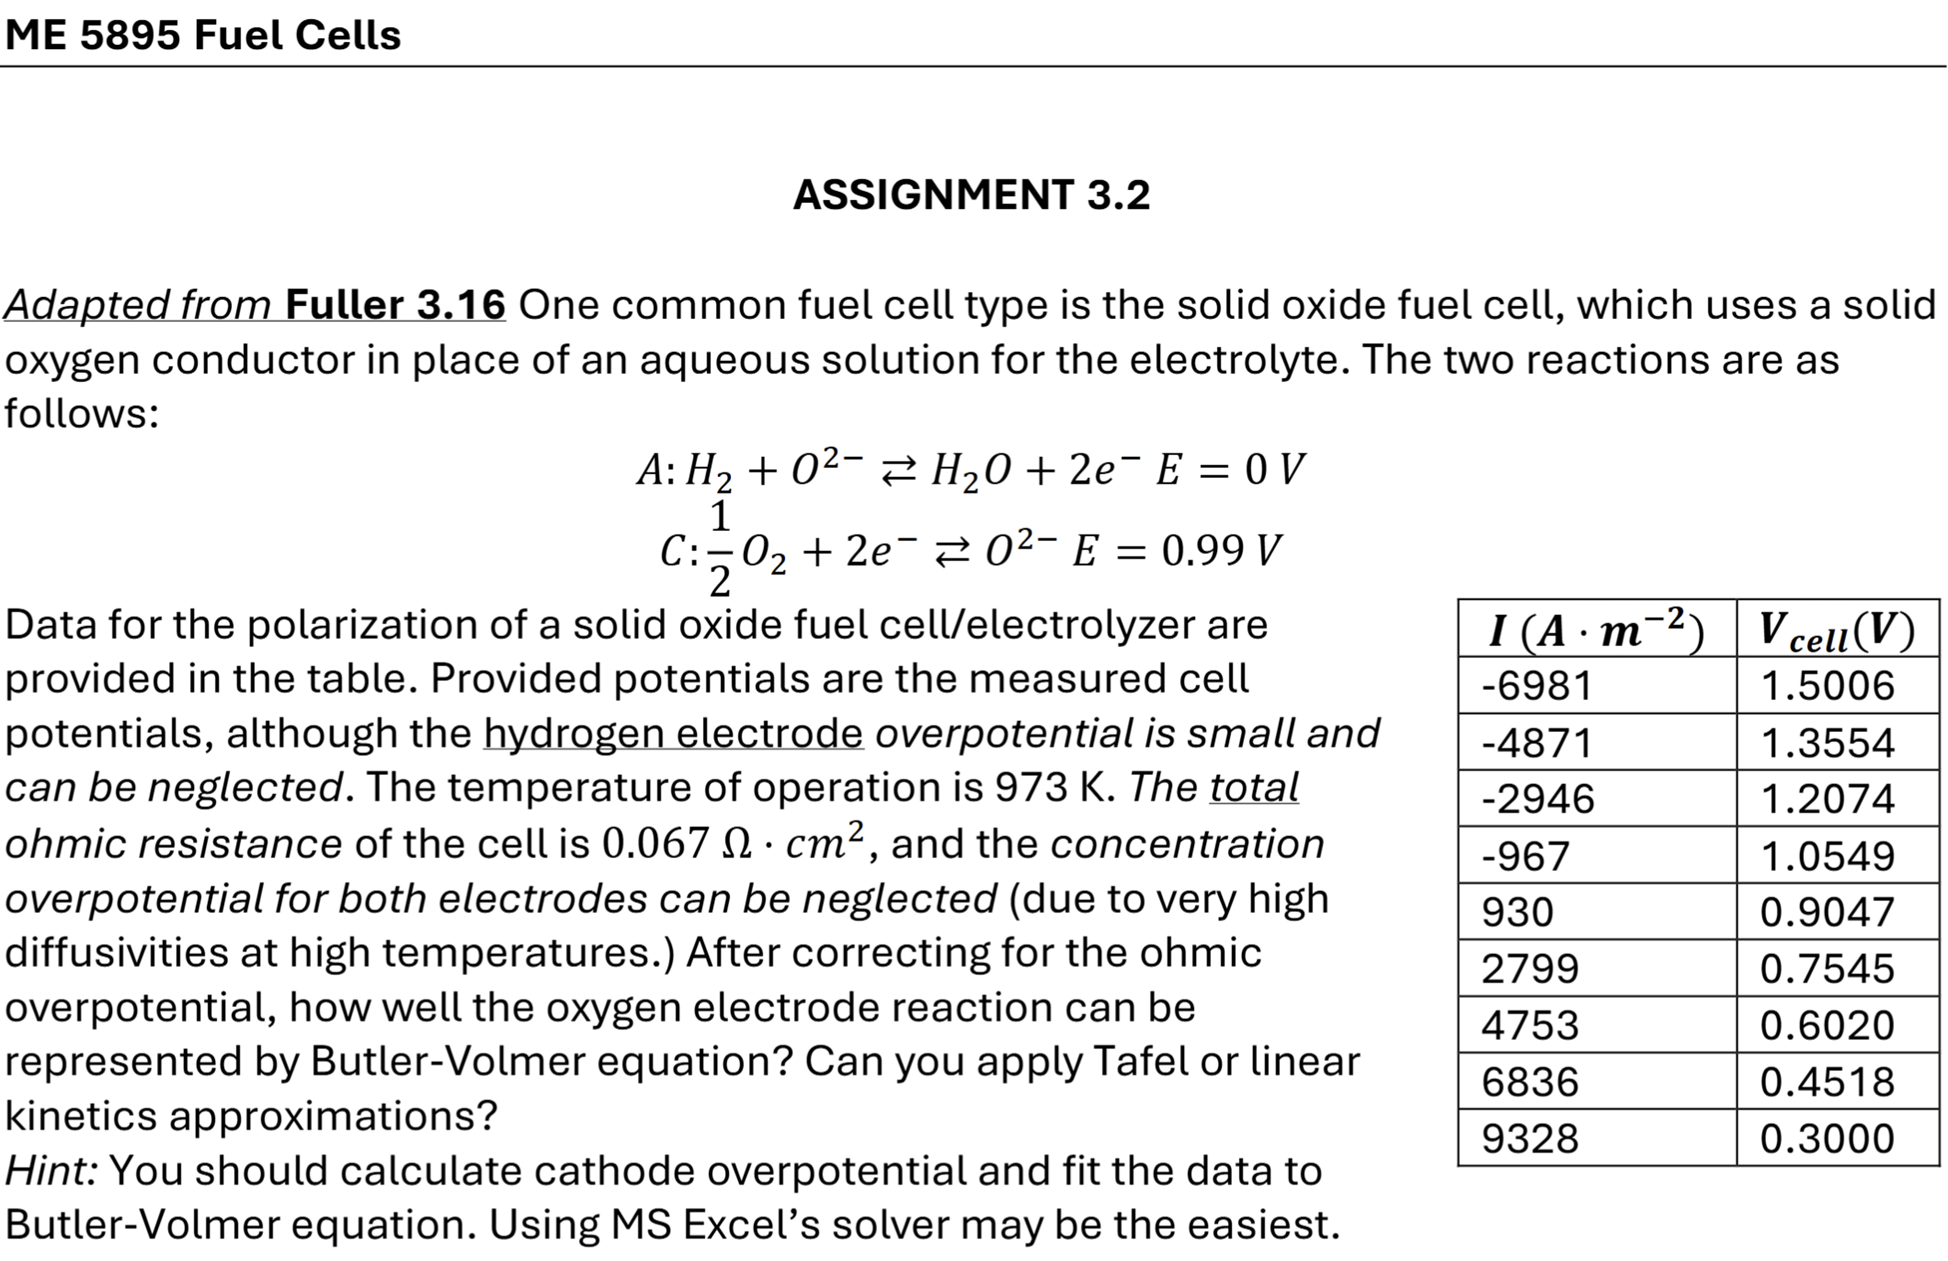

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.optimize import least_squares

In [ ]:
# given
T = 973.0            # K
F = 96485.0          # C/mol
R = 8.314            # J/mol/K
n = 2                # for 1/2 O2 + 2e- -> O^2-
E_rev = 0.99         # V 
R_ohm_area = 0.067   # ohmic resistance [ohm*cm^2]

data = pd.DataFrame({
    "I_A_m2": [-6981, -4871, -2946, -967, 930, 2799, 4753, 6836, 9328],
    "V_cell_V": [1.5006, 1.3554, 1.2074, 1.0549, 0.9047, 0.7545, 0.6020, 0.4518, 0.3000],
})

The cell voltage is given by the sum of the reversible potential, overpotential, and ohmic losses:
$V_{\mathrm{cell}} = E_{\mathrm{rev}} + \eta + i R_{\mathrm{ohm}}$

Rearranging for the overpotential, $\eta$, which is used for the Butler-Volmer model:
$\eta = V_{\mathrm{cell}} - E_{\mathrm{rev}} - i R_{\mathrm{ohm}}$

In [ ]:
# Convert current density to A/cm^2 
data["i_A_cm2"] = data["I_A_m2"] / 1e4

# Overpotential 
data["eta_V"] = data["V_cell_V"] - E_rev - data["i_A_cm2"] * R_ohm_area

data


In [ ]:
# Quick diagnostic plot: eta vs i (linear)
fig = plt.figure(figsize=(6,4))
plt.plot(data["i_A_cm2"], data["eta_V"], marker="o")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.xlabel("i (A/cm$^2$)")
plt.ylabel("eta (V)")
plt.title("Overpotential after ohmic correction")
plt.show()


In [ ]:
# --- 4) Butler–Volmer model ---
phi = n*F/(R*T)   # 1/V

def bv_current(i0, eta, alpha_a, alpha_c):
    """Return i (A/cm^2) from Butler–Volmer given eta (V)."""
    return i0*(np.exp(alpha_a*phi*eta) - np.exp(-alpha_c*phi*eta))

# Model wrappers for fitting
etas = data["eta_V"].to_numpy()
i_meas = data["i_A_cm2"].to_numpy()


In [ ]:
# --- 5) Fit Butler–Volmer parameters (least squares) ---
# We fit in A/cm^2. i0 should be >0, alphas >0.

def residuals_symmetric(p):
    # p = [log_i0, alpha]
    log_i0, alpha = p
    i0 = np.exp(log_i0)
    i_pred = bv_current(i0, etas, alpha, alpha)
    return (i_pred - i_meas)

def residuals_general(p):
    # p = [log_i0, alpha_a, alpha_c]
    log_i0, alpha_a, alpha_c = p
    i0 = np.exp(log_i0)
    i_pred = bv_current(i0, etas, alpha_a, alpha_c)
    return (i_pred - i_meas)

def residuals_alpha_sum_to_one(p):
    # p = [log_i0, alpha_a]; alpha_c = 1 - alpha_a
    log_i0, alpha_a = p
    alpha_c = 1.0 - alpha_a
    i0 = np.exp(log_i0)
    i_pred = bv_current(i0, etas, alpha_a, alpha_c)
    return (i_pred - i_meas)



p0 = np.array([np.log(1e-3), 0.5])
bounds = ([-np.inf, 1e-6], [np.inf, 1.0-1e-6])
res = least_squares(residuals_alpha_sum_to_one, p0, bounds=bounds)
log_i0_fit, alpha_a_fit = res.x
i0_fit = float(np.exp(log_i0_fit))
alpha_a_fit = float(alpha_a_fit)
# enforce alpha_a + alpha_c = 1 
alpha_c_fit = float(1.0 - alpha_a_fit)


print("Fit status:", res.status, res.message)
print(f"i0 = {i0_fit:.4e} A/cm^2")
print(f"alpha_a = {alpha_a_fit:.4f}")
print(f"alpha_c = {alpha_c_fit:.4f}")
print(f"SSE = {np.sum(res.fun**2):.4e}")


In [ ]:
# --- 6) Compare fit to data ---
i_fit = bv_current(i0_fit, etas, alpha_a_fit, alpha_c_fit)
data["i_fit_A_cm2"] = i_fit
data["i_err_A_cm2"] = data["i_fit_A_cm2"] - data["i_A_cm2"]

display(data)

fig = plt.figure(figsize=(6,4))
plt.plot(data["eta_V"], data["i_A_cm2"], "o", label="data")
plt.plot(data["eta_V"], data["i_fit_A_cm2"], "-", label="BV fit")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.xlabel("eta (V)")
plt.ylabel("i (A/cm$^2$)")
plt.title("Butler–Volmer fit")
plt.legend()
plt.show()

fig = plt.figure(figsize=(6,4))
plt.plot(data["eta_V"], data["i_err_A_cm2"], "o-")
plt.axhline(0, linewidth=1)
plt.xlabel("eta (V)")
plt.ylabel("i_fit - i (A/cm$^2$)")
plt.title("Residuals")
plt.show()


In [ ]:
# --- 7) Tafel analysis (optional) ---
# Tafel form for anodic branch (eta>0):  eta = (RT/(alpha_a nF)) * ln(i/i0)  for sufficiently large eta
# Cathodic (eta<0): eta = -(RT/(alpha_c nF)) * ln(|i|/i0)  (sign conventions vary; we fit slopes empirically)

# Choose a threshold to define "Tafel region" (tune as needed)
eta_thresh = 0.15

df = data.copy()

# Use magnitude for log; keep sign of eta.
df["log10_abs_i"] = np.log10(np.abs(df["i_A_cm2"]))

# Split branches and filter by |eta|
an = df[(df["eta_V"] > eta_thresh)]
ca = df[(df["eta_V"] < -eta_thresh)]

def linfit(x, y):
    x = np.asarray(x); y = np.asarray(y)
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return float(m), float(b)

if len(an) >= 2:
    m_an, b_an = linfit(an["log10_abs_i"], an["eta_V"])
    print(f"Anodic Tafel (eta vs log10|i|): eta ≈ {m_an:.4f} * log10|i| + {b_an:.4f}")
else:
    m_an = b_an = None
    print("Not enough anodic points above threshold for Tafel fit.")

if len(ca) >= 2:
    m_ca, b_ca = linfit(ca["log10_abs_i"], ca["eta_V"])
    print(f"Cathodic Tafel (eta vs log10|i|): eta ≈ {m_ca:.4f} * log10|i| + {b_ca:.4f}")
else:
    m_ca = b_ca = None
    print("Not enough cathodic points below threshold for Tafel fit.")

# Plot Tafel
fig = plt.figure(figsize=(6,4))
plt.plot(df["log10_abs_i"], df["eta_V"], "o", label="data")
if m_an is not None:
    xs = np.linspace(an["log10_abs_i"].min(), an["log10_abs_i"].max(), 50)
    plt.plot(xs, m_an*xs + b_an, "-", label="anodic fit")
if m_ca is not None:
    xs = np.linspace(ca["log10_abs_i"].min(), ca["log10_abs_i"].max(), 50)
    plt.plot(xs, m_ca*xs + b_ca, "-", label="cathodic fit")
plt.axhline(0, linewidth=1)
plt.xlabel("log10(|i|)  (i in A/cm$^2$)")
plt.ylabel("eta (V)")
plt.title("Tafel plot (use |i| for log scale)")
plt.legend()
plt.show()


In [ ]:
# --- 8) Notes / knobs to try ---
# - If BV fit looks poor, try:
#   (a) fitting only one branch at a time (eta>0 or eta<0)
#   (b) fixing alpha_a=alpha_c=0.5 and fitting only i0
#   (c) allowing E_rev to shift slightly and fitting it too (add as parameter)
# - If data are nearly linear in V vs i, kinetics may be weakly identifiable after ohmic correction.
